<a href="https://colab.research.google.com/github/Snafkin547/Quantum-ML/blob/main/QML_Ch9_Quantum_Bayesian_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install numpy scipy matplotlib ipython pandas sympy nose seaborn
!pip install scikit-learn
!pip install pylatexenc ipywidgets qutip
!pip install kaggle

from google.colab import drive
import os

#Google Drive mounting to Google Colab
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/QML/Kaggle"
#Change the working directory
%cd /content/gdrive/My Drive/QML/Kaggle/

#Check if the directory was properly changed
%pwd

import pandas as pd

train=pd.read_csv('./train.csv')

In [5]:
def chance_to_survive(age):
  pop=train[train['Age']==age]
  surv=pop[pop['Survived']==1]
  prob=len(surv)/(len(pop)+1)
  return "A {} - year old passenger had a chance to survive of {}".format(age, prob)

print(chance_to_survive(47))
print(chance_to_survive(48))

A 47 - year old passenger had a chance to survive of 0.1
A 48 - year old passenger had a chance to survive of 0.6


In [11]:
max_child_age=8

#Child survival prob
pop_child=train[train['Age']<=max_child_age]
surv_child=pop_child[pop_child['Survived']==1]
p_child=len(surv_child)/len(pop_child)

#Adult survival prob
pop_adult=train[train['Age']>max_child_age]
surv_adult=pop_adult[pop_adult['Survived']==1]
p_adult=len(surv_adult)/len(pop_adult)

print("Child survival rate: {}".format(round(p_child,2)))
print("Adult survival rate: {}".format(round(p_adult,2)))



Child survival rate: 0.67
Adult survival rate: 0.38


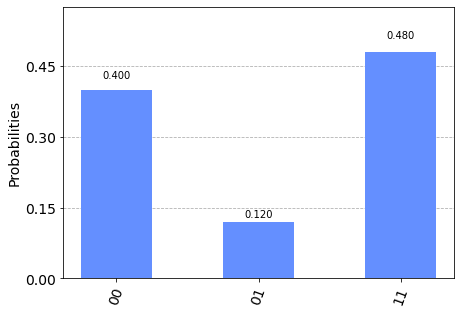

In [17]:
from functools import reduce
from qiskit import QuantumCircuit, Aer, execute, ClassicalRegister, QuantumRegister
from math import asin, sqrt, ceil, pi
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def prob_to_angle(prob):

  return 2*asin(sqrt(prob))

qc=QuantumCircuit(2)

# Assigning |1> 0.4
qc.ry(prob_to_angle(0.4),0)

# Switch probs
qc.x(0)

# work on remainder
qc.cry(prob_to_angle(0.8),0,1)

results=execute(qc, Aer.get_backend('statevector_simulator')).result().get_counts()

plot_histogram(results)


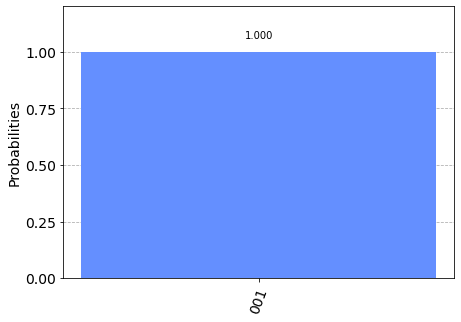

In [29]:
# Self-made CCNOT Gate

theta=pi/2

def ccnot(qc):
  qc.cry(theta,1,2)
  qc.cx(0,1)
  qc.cry(-theta,1,2)
  qc.cx(0,1)
  qc.cry(theta, 0,2)

  return execute(qc, Aer.get_backend('statevector_simulator')).result().get_counts()

qc=QuantumCircuit(3)

qc.x(0)

plot_histogram(ccnot(qc))


### Circuit Implementation

In [59]:
max_child_age=8

#Prob of being child
pop_child=train[train['Age']<=max_child_age]
p_child=len(pop_child)/len(train)

#Adult survival prob
pop_female=train[train['Sex']=="female"]
p_female=len(pop_female)/len(train)

qc=QuantumCircuit(3)

#Q0 to be prob child, Q1 to be prob female
qc.ry(prob_to_angle(p_child),0)
qc.ry(prob_to_angle(p_female),1)

def ccry(qc, theta, control1, control2, controlled):
  qc.cry(theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(-theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(theta/2, control1, controlled)

In [ ]:
# female children
p_surv_f_c=len(train[train['Sex']=="female"][train['Age']<=max_child_age][train['Survived']==1])/len(train[train['Sex']=="female"][train['Age']<=max_child_age])
# female adults
p_surv_f_a=len(train[train['Sex']=="female"][train['Age']>max_child_age][train['Survived']==1])/len(train[train['Sex']=="female"][train['Age']>max_child_age])
# male children
p_surv_m_c=len(train[train['Sex']=="male"][train['Age']<=max_child_age][train['Survived']==1])/len(train[train['Sex']=="male"][train['Age']<=max_child_age])
# male adults
p_surv_m_a=len(train[train['Sex']=="male"][train['Age']>max_child_age][train['Survived']==1])/len(train[train['Sex']=="male"][train['Age']>max_child_age])

Q2=1 is survivors and Q2=0 is victims


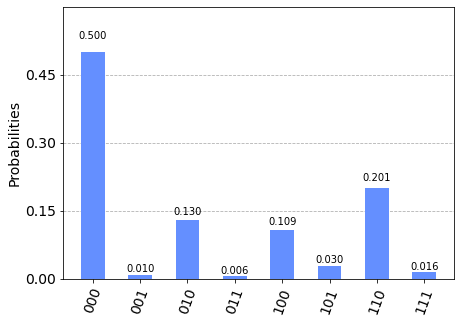

In [61]:
# state |00> to conditional prob of male adults
qc.x(0)
qc.x(1)
ccry(qc, prob_to_angle(p_surv_m_a), 0,1,2)
qc.x(0)
qc.x(1)

# state |01> to conditional prob of male children
qc.x(0)
ccry(qc, prob_to_angle(p_surv_m_c), 0,1,2)
qc.x(0)

# state |10 to conditional prob of female children
qc.x(1)
ccry(qc, prob_to_angle(p_surv_f_a), 0,1,2)
qc.x(1)

# state |11> to conditional prob of female children
ccry(qc, prob_to_angle(p_surv_f_c), 0,1,2)

results=execute(qc, Aer.get_backend('statevector_simulator')).result().get_counts()

print("Q2=1 is survivors and Q2=0 is victims")
plot_histogram(results)


1 is survivors and 0 is victims


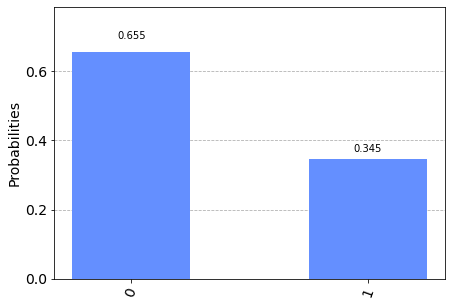

In [64]:
# To summarize Q2=0 and Q2=1, adding measurement

qr=QuantumRegister(3)
cr=ClassicalRegister(1)
qc=QuantumCircuit(qr, cr)

#Q0 to be prob child, Q1 to be prob female
qc.ry(prob_to_angle(p_child),0)
qc.ry(prob_to_angle(p_female),1)

# state |00> to conditional prob of male adults
qc.x(0)
qc.x(1)
ccry(qc, prob_to_angle(p_surv_m_a), 0,1,2)
qc.x(0)
qc.x(1)

# state |01> to conditional prob of male children
qc.x(0)
ccry(qc, prob_to_angle(p_surv_m_c), 0,1,2)
qc.x(0)

# state |10> to conditional prob of female children
qc.x(1)
ccry(qc, prob_to_angle(p_surv_f_a), 0,1,2)
qc.x(1)

# state |11> to conditional prob of female children
ccry(qc, prob_to_angle(p_surv_f_c), 0,1,2)

qc.measure(qr[2], cr[0])

results=execute(qc, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
print("1 is survivors and 0 is victims")
plot_histogram(results)